In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('../../src')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from losses import _reconstruction_loss
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p, load_dataloader_and_pretrained_model
from captum.attr import *

# trim modules
sys.path.append('../../lib/trim')
from trim import TrimModel

# wt modules
from wavelet_transform import Wavelet_Transform, DTCWT_Mask, tuple_Attributer, create_images_high_attrs, compute_tuple_dim
import pywt

## load data and model

In [2]:
# get dataloader and model
train_loader, model = load_dataloader_and_pretrained_model(p)

## set up wavelet transform and trim model

In [3]:
# pywt.wavelist()
# wavelet transform
wt1 = Wavelet_Transform(wt_type='DWT', J=5, wave='db3')
wt2 = Wavelet_Transform(wt_type='DWT', J=5, wave='bior2.2')
wt3 = Wavelet_Transform(wt_type='DTCWT', J=5)

# prepend transformation onto network
mt1 = TrimModel(model, wt1.inverse)
mt2 = TrimModel(model, wt2.inverse)
mt3 = TrimModel(model, wt3.inverse)

In [122]:
# input
torch.manual_seed(50)
ims, params = iter(train_loader).next()
im = ims[0:1].to(device)
im.requires_grad = True

# wavelet transform
t1 = wt1(im)
t2 = wt2(im)
t3 = wt3(im)
tot_dim1 = compute_tuple_dim(t1)
tot_dim2 = compute_tuple_dim(t2)
tot_dim3 = compute_tuple_dim(t3)
print(tot_dim1, tot_dim2, tot_dim3)

# interp score
# attr_methods = 'InputXGradient'
attr_methods = 'IntegratedGradient'
attributer1 = tuple_Attributer(mt1, attr_methods=attr_methods)
attributer2 = tuple_Attributer(mt2, attr_methods=attr_methods)
attributer3 = tuple_Attributer(mt3, attr_methods=attr_methods)
attributions1 = list(attributer1(t1, target=1))
attributions2 = list(attributer2(t2, target=1))
attributions3 = list(attributer3(t3, target=1))
for i in range(len(t1)):
    attributions1[i] = -1*(attributions1[i])
    attributions2[i] = -1*(attributions2[i])
    attributions3[i] = -1*(attributions3[i])
attributions1 = tuple(attributions1)
attributions2 = tuple(attributions2)    
attributions3 = tuple(attributions3)    

69831 69831 262144


In [134]:
# # sort attribution
# b = torch.tensor([])
# c = torch.tensor([])
# n = len(attributions1)

# for k in range(n):
#     a = attributions3[k].cpu().reshape(-1)
#     b = torch.cat((b,a))
#     a = t3[k].cpu().reshape(-1)
#     c = torch.cat((c,a))
# b = b.detach().cpu().numpy()
# c = c.detach().cpu().numpy()

# idx = np.argsort(b)
# # plt.plot(abs(c[idx]))
# plt.plot(np.sort(b))

## sort in decreasing order

In [124]:
# get images with high attributions
num_sp = 20
results1 = create_images_high_attrs(attributions1, t1, wt1.inverse, tot_dim1, num_sp)
results2 = create_images_high_attrs(attributions2, t2, wt2.inverse, tot_dim2, num_sp)
results3 = create_images_high_attrs(attributions3, t3, wt3.inverse, tot_dim3, num_sp)

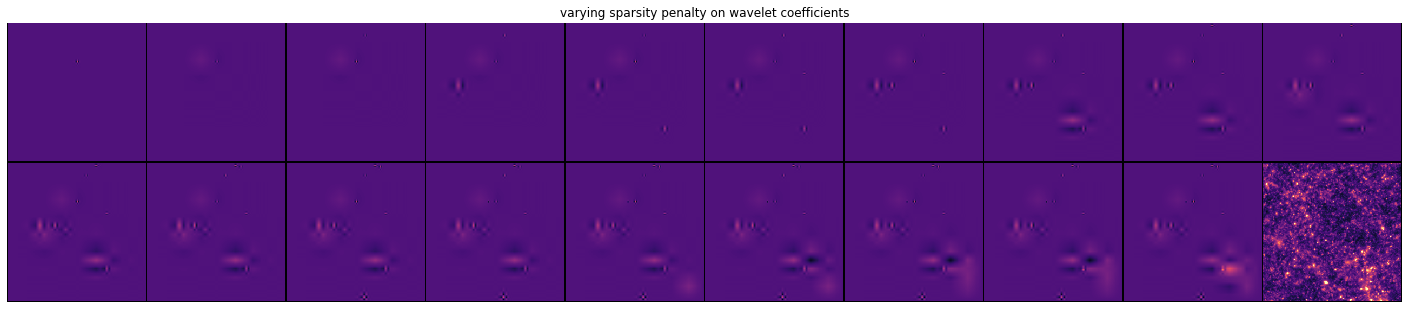

In [125]:
# viz
plt.figure(figsize=(25,25))
vmax=0.15
vmin=-0.05
n_row = 2
n_col = 10
d = 256 + 2
mosaic = np.zeros((d*n_row,d*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*d:(i+1)*d,j*d:(j+1)*d] = np.pad(results1[indx].squeeze().data.cpu().numpy(),(1,1),mode='constant', constant_values=-50)
        indx += 1
plt.title("varying sparsity penalty on wavelet coefficients")
plt.imshow(mosaic, cmap='magma', vmax=vmax, vmin=vmin)
plt.axis('off')    
plt.show()         
        

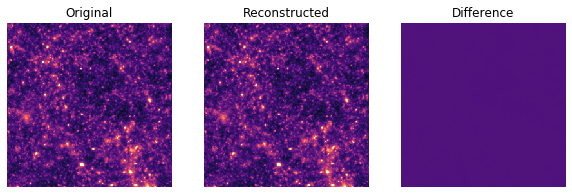

Recon Error: 2.2905180685484083e-06


In [126]:
# check reconstruction quality
viz_im_r(im[0,0], results1[-1][0,0])
print('Recon Error:', torch.norm(im[0,0].cpu() - results1[-1][0,0]).item())

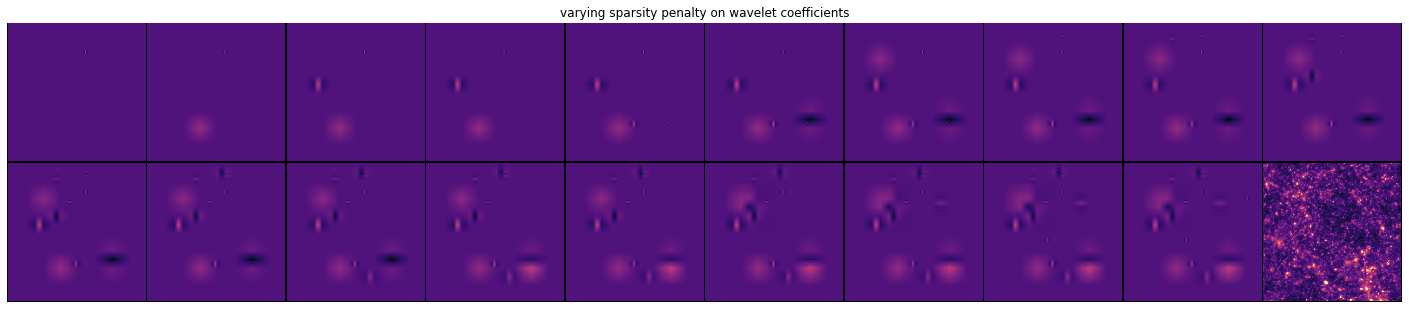

In [127]:
# viz
plt.figure(figsize=(25,25))
vmax=0.15
vmin=-0.05
n_row = 2
n_col = 10
d = 256 + 2
mosaic = np.zeros((d*n_row,d*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*d:(i+1)*d,j*d:(j+1)*d] = np.pad(results2[indx].squeeze().data.cpu().numpy(),(1,1),mode='constant', constant_values=-50)
        indx += 1
plt.title("varying sparsity penalty on wavelet coefficients")
plt.imshow(mosaic, cmap='magma', vmax=vmax, vmin=vmin)
plt.axis('off')    
plt.show()         
        

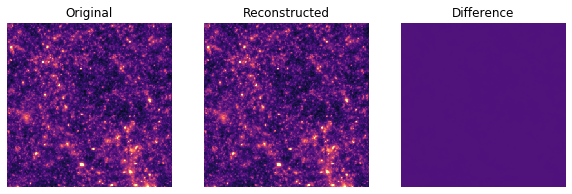

Recon Error: 2.775386519715539e-06


In [128]:
# check reconstruction quality
viz_im_r(im[0,0], results2[-1][0,0])
print('Recon Error:', torch.norm(im[0,0].cpu() - results2[-1][0,0]).item())

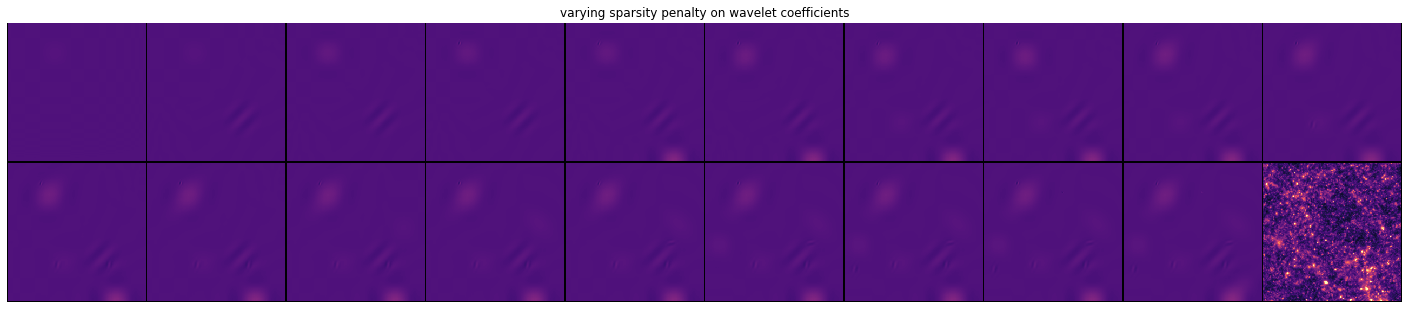

In [129]:
# viz
plt.figure(figsize=(25,25))
vmax=0.15
vmin=-0.05
n_row = 2
n_col = 10
d = 256 + 2
mosaic = np.zeros((d*n_row,d*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*d:(i+1)*d,j*d:(j+1)*d] = np.pad(results3[indx].squeeze().data.cpu().numpy(),(1,1),mode='constant', constant_values=-50)
        indx += 1
plt.title("varying sparsity penalty on wavelet coefficients")
plt.imshow(mosaic, cmap='magma', vmax=vmax, vmin=vmin)
plt.axis('off')    
plt.show()         
        

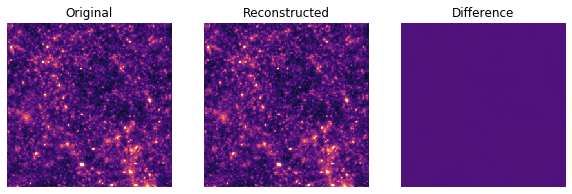

Recon Error: 1.667380047365441e-06


In [130]:
# check reconstruction quality
viz_im_r(im[0,0], results3[-1][0,0])
print('Recon Error:', torch.norm(im[0,0].cpu() - results3[-1][0,0]).item())

In [131]:
corr_mat = []
for i in range(num_sp):
    corrs = []
    rec1 = results1[i]
    for j in range(num_sp):
        rec2 = results2[j]
        corrs.append(np.corrcoef(rec1.detach().numpy().reshape(-1), rec2.detach().numpy().reshape(-1))[0,1])
    corr_mat.append(np.array(corrs))
corr_mat = np.stack(corr_mat, axis=0)

In [132]:
for i in range(num_sp):
    print(np.argmax(corr_mat[i]), np.max(corr_mat[i]))

19 0.020874952663547018
6 0.0664638870755582
7 0.06507235776302157
2 0.3475512264851662
2 0.3216760259261182
2 0.3170672264620108
2 0.2788616146100646
2 0.18898829864827563
2 0.18609737704949708
2 0.1692842692016966
2 0.1672720623786304
2 0.16616750753334086
2 0.15668125540558125
2 0.1558424222218564
2 0.13182627589809842
5 0.28993670158191737
5 0.25703761910457057
5 0.2563302451300992
13 0.49713941414625035
19 0.9999999999999696
